In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import numpy as np
import scipy.stats as st
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [2]:
path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-pjatakova/Module_5/Lesson_10/dating_data.csv'

In [3]:
dating_data = pd.read_csv(path_to_file)

<h3>В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч

Нужно оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

In [4]:
dating_data

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


<h3> I. Влияние группы на действия

<strong><em>Метрика.</strong></em> Для определения целевой метрики нужно исходить из цели существования приложений для онлайн-знакомств. Основная цель - это знакомство с человеком. Предполагаю, что познакомиться с человеком возможно только лишь в том случае, если пользователи поставили друг другу <strong>лайк</strong>, то есть <strong>смэтчились</strong>. 

Тогда, в нашем случае, целевой метрикой будет являться <strong><em>факт мэтча между пользователями, иными словами, количество мэтчей между пользователями.</strong></em> 

<h4> Проведем предварительный анализ данных

In [5]:
# Размер данных
dating_data.shape

(14514, 4)

In [6]:
# Наличие пропущенных значений
dating_data.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [7]:
# Количество уникальных значений
dating_data.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

In [8]:
# Типы данных
dating_data.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [9]:
# Посмотрим на мэтчи и немэтчи по группам и на общие показатели
df_matches_groups_total = pd.crosstab(dating_data.is_match, dating_data.group, margins=True, margins_name="total")

In [10]:
df_matches_groups_total

group,0,1,total
is_match,,,
0,3858,5813,9671
1,934,3909,4843
total,4792,9722,14514


In [11]:
# Посмотрим на мэтчи и немэтчи по группам
df_matches_groups = pd.crosstab(dating_data.is_match, dating_data.group)

In [12]:
df_matches_groups

group,0,1
is_match,,
0,3858,5813
1,934,3909


Мэтч - это 1, "немэтч" - это 0

In [13]:
# Доля мэтчей в экспериментальной группе во всех взаимодействиях между пользователями в экспериментальной группе
round(3909/9722*100, 2)

40.21

In [14]:
# Доля мэтчей в базовой группе во всех взаимодействиях между пользователями в базовой группе
round(934/4792*100, 2)

19.49

In [15]:
# Доля немэтчей в экспериментальной группе 1 во всех взаимодействиях между пользователями в экспериментальной группе
round(5813/9722*100, 2)

59.79

In [16]:
# Доля немэтчей в базовой группе 0 во всех взаимодействиях между пользователями в базовой группе
round(3858/4792*100, 2)

80.51

Можно сказать, что доля мэтчей с новым алгоритмом увеличилась, а доля немэтчей в группе с новым алгоритмом уменьшилась по сравнению с группой со старым алгоритмом. Построим график для наглядности

In [17]:
# Отберем данные с мэтчами по группам для дальнейшего удобного построения графиков
match = dating_data.query('is_match == 1').groupby('group', as_index=False).agg({'is_match': 'count'})

In [18]:
# Данные немэтчей по группам
not_match = dating_data.query('is_match == 0')\
    .groupby('group', as_index=False)\
    .agg({'is_match': 'count'})\
    .rename(columns={'is_match': 'not_match'})

In [19]:
# Объединим
total = match.merge(not_match)

In [20]:
# Добавим столбец, где посчитаем общие взаимодействия по группам
total['total_on_group'] = total['is_match']+total['not_match']

In [21]:
# Найдем долю немэтчей в общих взаимодействиях по группам
total['not_match/total_on_group'] = total['not_match']/total['total_on_group']*100

In [22]:
# Найдем долю мэтчей в общих взаимодействиях по группам
total['is_match/total_on_group'] = total['is_match']/total['total_on_group']*100

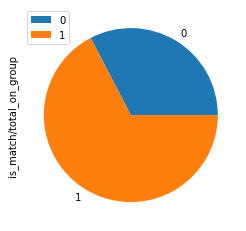

In [23]:
# Построим круговую диаграмму с отображением доли мэтчей в общих взаимодействиях по группам
total.plot(kind='pie', y='is_match/total_on_group')

График позволяет сделать вывод о том, что доля мэтчей в общем числе взаимодействий больше в экспериментальной группе, чем в базовой, где использовался старый алгоритм

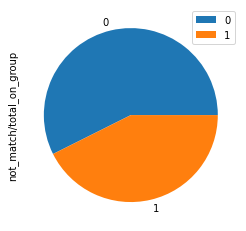

In [24]:
# Построим круговую диаграмму с отображением доли немэтчей в общих взаимодействиях по группам
total.plot(kind='pie', y='not_match/total_on_group')

График позволяет сделать вывод о том, что доля немэтчей в общем числе взаимодействий меньше в экспериментальной группе, чем в базовой, где использовался старый алгоритм

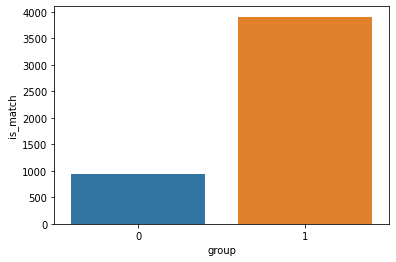

In [25]:
# Построим график мэтчей (абсолютные величины) с разбивкой по группам. 
# Видно, что количество мэтчей в экспериментальной группе больше, чем в 0.
sns.barplot(x='group', y='is_match', data = match)

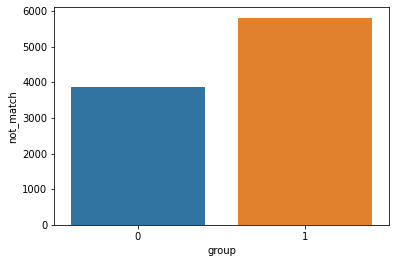

In [26]:
# Построим график отсутствия мэтчей (абсолютные показатели) с разбивкой по группам. 
# Видно, что отсутствие мэтчей в экспериментальной группе больше.
sns.barplot(x='group', y='not_match', data = not_match)

Видим, что доля и абсолютная величина мэтчей в экспериментальной группе 1 выше, чем в базовой, где использовался старый алгоритм. Также, видим, что доля и абсолютная величина немэтчей в экспериметальной группе 1 ниже, чем в базовой. Но позволяет ли данный факт и данные графики судить об эффективности и обоснованности нововведений? Стоит предположить, что нет. Поэтому для дальнейшей идентификации более точных результатов необходимо провести статистическое тестирование 

Поскольку в нашем случае фигурируют категориальные (фиктивные) переменные, воспользуемся <strong><em>хи-квадрат</strong></em>

<strong>Сформулируем нулевую гипотезу Н0</strong> о том, что введение нового алгоритма в работу приложения никак не повлияет на количество мэтчей и их долю в общих количествах взаимодействий между пользователями (отсутствие взаимосвязи между переменными). Соответственно, <strong>H1 - альтернативная гипотеза о влиянии нового алгоритма на результирующие показатели</strong> (наличие взаимосвязи между переменными)

In [27]:
from scipy.stats import chi2_contingency, chi2

In [28]:
# Проводим тест
stat, p, dof, expected = chi2_contingency(df_matches_groups)

In [29]:
stat, p

(618.6889141576197, 1.441829916366341e-136)

In [30]:
# Сравним значение статистики с нужным порогом
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs (stat)>= critical:
    print('Отклоняем нулевую гипотезу H0')
else:
    print('Принимаем нулевую гипотезу H0')

Отклоняем нулевую гипотезу H0


In [31]:
# Сравним p-value c нужным порогом
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем нулевую гипотезу H0')
else:
    print('Принимаем нулевую гипотезу H0')

Отклоняем нулевую гипотезу H0


Таким образом, хи-квадрат показал, что нам необходимо отклонить нулевую гипотезу H0 о том, что введение нового алгоритма в работу приложения никак не повлияет на количество мэтчей и их долю в общих количествах взаимодействий между пользователями.
Принимаем альтернативную гипотезу H1 о влиянии нового алгоритма на результирующие показатели. И как ранее было замечено, влияние положительное. Соответственно, новый алгоритм улучшил качество сервиса 